1. Delivery
2. Crane Operation Time - not being ready 8- 10
3. Every unit cost 5000 $ - more than 4 worker
4. only 4 types of pbu - 5, 10, 15 

Equations

$ Y_{warehouse}(t) =  Y_{warehouse}(t-1) + x_{delivered}(t) - x_{load}(t) $


$ Y_{parking}(t) =  Y_{parking}(t-1) + x_{load}(t) - x_{hoist}(t) $


$ Y_{Hoist}(t) =  Y_{Hoist}(t-1) + x_{hoist}(t) - x_{install}(t) $


$ Y_{install}(t) =  Y_{install}(t-1) + x_{install}(t) $




In [1]:
import pandas as pd 
import datetime
import numpy as np
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt
%matplotlib inline

## Setting up the optimization

In [2]:
# Create the mip solver with the SCIP backend.
solver = pywraplp.Solver.CreateSolver('SCIP')
 
 

## Generate Random delivery Data

In [3]:
delivery=pd.DataFrame([])
delivery["date"]=pd.date_range(start='1/1/2022', end='4/30/2022')
#delivery["shipment"]=np.random.poisson(10, len(delivery))
delivery["shipment"]=0
delivery["shipment"].iloc[0:89]=1

delivery["time_index"]=range(1,len(delivery)+1)
n=len(delivery)

C:\Users\Aligo\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [4]:
delivery.head()

,date,shipment,time_index
0,2022-01-01,1,1
1,2022-01-02,1,2
2,2022-01-03,1,3
3,2022-01-04,1,4
4,2022-01-05,1,5


## Defining Variables

$x_{delivered}(t)$     $~~~~~~~~~~~~~~~~$     PBUs delivered into the warehouse at each time frame

$Y_{warehouse}(t)$     $~~~~~~~~~~~~~~~~$     PBUs in warehouse at each time frame

$x_{load}(t)$     $~~~~~~~~~~~~~~~~$     PBUs loaded from the warehouse into the parking at each time frame

$Y_{parked}(t)$     $~~~~~~~~~~~~~~~~$     PBUs in parking at each time frame

$x_{hoist}(t)$     $~~~~~~~~~~~~~~~~$     PBUs selected from the parking, and and to be hoisted at each time frame

$Y_{hoisted}(t)$     $~~~~~~~~~~~~~~~~$     PBUs which are hoisted at each time frame

$x_{install}(t)$     $~~~~~~~~~~~~~~~~$     PBUs selected from the hoisted ones, and to be installed at each time frame

$Y_{installed}(t)$     $~~~~~~~~~~~~~~~~$     PBUs installed at each time frame



$C_{hoist}$     $~~~~~~~~~~~~~~~~$     Maximum PBUs can be hoisted at each time frame

$C_{install}$     $~~~~~~~~~~~~~~~~$     Maximum PBUs can be installed at each time frame

$C_{parked}$     $~~~~~~~~~~~~~~~~$     Maximum PBUs in parking at each time frame

$C_{load}$     $~~~~~~~~~~~~~~~~$     Maximum PBUs loaded from the warehouse into the parking at each time frame

$C_{installed}$     $~~~~~~~~~~~~~~~~$   Maximum  PBUs installed 

In [5]:
C_hoist= 10
C_install= 8
C_parked= 30
C_load=50
C_installed=44

In [6]:
Initial_Warehouse_Quantity=0

In [7]:
infinity = solver.infinity()
Y_warehouse={}

for i in range (0,n):
    Y_warehouse[i]=solver.IntVar(lb=0,ub=infinity,name="Y_warehouse_%i" % i)

In [8]:
Y_parked={}

for i in range (0,n):
    Y_parked[i]=solver.IntVar(lb=0,ub=C_parked,name="Y_parked_%i" % i)

In [9]:
x_load={}

for i in range (0,n):
    x_load[i]=solver.IntVar(lb=0,ub=C_load,name="x_load_%i" % i)

In [10]:
x_hoist={}
for i in range (0,n):
    x_hoist[i]=solver.IntVar(lb=0,ub=C_hoist,name="x_hoist_%i" % i)

In [11]:
Y_hoisted={}
for i in range (0,n):
    Y_hoisted[i]=solver.IntVar(lb=0,ub=C_hoist,name="Y_hoisted_%i" % i)

In [12]:
x_install={}
for i in range (0,n):
    x_install[i]=solver.IntVar(lb=0,ub=C_install,name="x_install_%i" % i)

In [13]:
Y_installed={}
for i in range (0,n):
    Y_installed[i]=solver.IntVar(lb=0,ub=C_installed,name="Y_installed_%i" % i)

In [14]:
print('Number of variables =', solver.NumVariables())


Number of variables = 840


## Defining Mathematical Relationship Between Variables 

The number of the PBUs in the warehouse at time $t$ = The number of the PBUs in the warehouse at time $t-1$  +  the number of PBUs delivered to warehouse at time $t$   -  the number of PBUs loaded from warehouse to parking at time $t$

$ Y_{warehouse}(t) =  Y_{warehouse}(t-1) + x_{delivered}(t) - x_{load}(t) $


In [15]:
for t in range(1,n):
    solver.Add(Y_warehouse[t]== Y_warehouse[t-1] + delivery["shipment"].values[t] - x_load[t])


The number of PBUs in parking at time $t$ = The number of PBUs in parking at time $t-1$ + The number of PBUs loaded from warehouse to parking at time $t$ - The number of PBUs selected from the parking, and to be hoisted at time $t$

$ Y_{parked}(t) =  Y_{parked}(t-1) + x_{load}(t) - x_{hoist}(t) $


In [16]:
for t in range(1,n):
    solver.Add(Y_parked[t]== Y_parked[t-1] + x_load[t] - x_hoist[t])

The number of PBUs which are hoisted at each time frame at time $t$ =  The number of PBUs which are hoisted at each time frame at time $t-1$ + The number of PBUs selected from the parking, and to be hoisted at time $t$ - The number PBUs selected from the hoisted ones, and to be installed at each time frame

$ Y_{Hoist}(t) =  Y_{Hoist}(t-1) + x_{hoist}(t) - x_{install}(t) $


In [17]:
for t in range(1,n):
    solver.Add(Y_hoisted[t]== Y_hoisted[t-1] + x_hoist[t] - x_install[t])

The Number of PBUs selected from the hoisted ones, and to be installed at each time frame at time $t$ = The Number of PBUs selected from the hoisted ones, and to be installed at each time frame at time $t-1$ + The number of PBUs selected from the hoisted ones, and to be installed at each time frame

$ Y_{installed}(t) =  Y_{installed}(t-1) + x_{install}(t) $


In [18]:
for t in range(1,n):
    solver.Add(Y_installed[t]== Y_installed[t-1] + x_install[t])

In [19]:
Initial_Warehouse_Quantity=0

In [20]:
solver.Add(Y_warehouse[0] ==Initial_Warehouse_Quantity)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x000001E5C6CDB8D0> >

In [21]:
print('Number of constraints =', solver.NumConstraints())

Number of constraints = 477


In [22]:
KPI=sum(Y_warehouse[i] for i in range( 0,n))

In [23]:
solver.Minimize(KPI)
#Y_warehouse[89]
solver.Solve()



0

In [24]:
solver.Objective().Value()

134.0

In [25]:
solver.OPTIMAL

0

Y_parked

In [26]:
Y_warehouse_solution=[Y_warehouse[i].solution_value() for i in range(0,n)]
x_load_solution=[x_load[i].solution_value() for i in range(0,n)]
Y_parked_solution=[Y_parked[i].solution_value() for i in range(0,n)]
x_hoist_solution=[x_hoist[i].solution_value() for i in range(0,n)]
Y_hoisted_solution=[Y_hoisted[i].solution_value() for i in range(0,n)]
x_install_solution=[x_install[i].solution_value() for i in range(0,n)]
Y_installed_solution=[Y_installed[i].solution_value() for i in range(0,n)]
 
 

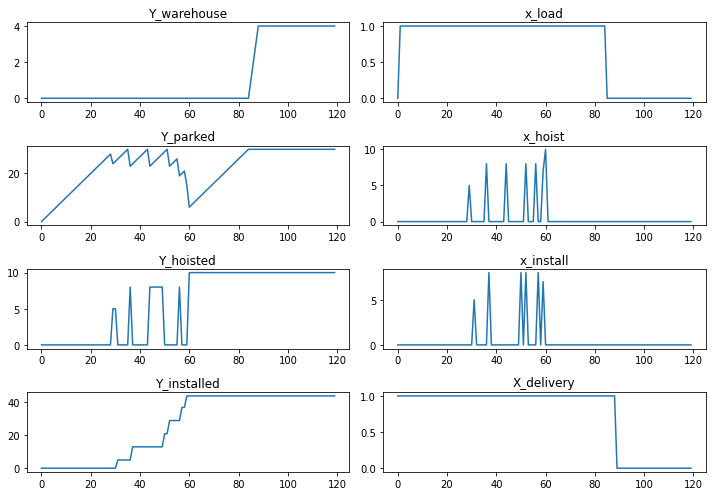

In [27]:
fig, ax = plt.subplots(4, 2 ,figsize= (10,7) )

ax[0,0].plot(Y_warehouse_solution)
ax[0, 0].set_title("Y_warehouse")

ax[0,1].plot(x_load_solution)
ax[0,1].set_title("x_load")

ax[1,0].plot(Y_parked_solution)
ax[1, 0].set_title("Y_parked")

ax[1,1].plot(x_hoist_solution)
ax[1, 1].set_title("x_hoist")

ax[2,0].plot(Y_hoisted_solution)
ax[2, 0].set_title("Y_hoisted")

ax[2,1].plot(x_install_solution)
ax[2, 1].set_title("x_install")

ax[3,0].plot(Y_installed_solution)
ax[3, 0].set_title("Y_installed")

ax[3,1].plot(delivery["shipment"].values)
ax[3, 1].set_title("X_delivery")
fig.tight_layout()

 